In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.semi_parametric import CoxPHModel,NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.models.multi_task import LinearMultiTaskModel,NeuralMultiTaskModel
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel,ExtraSurvivalTreesModel,RandomSurvivalForestModel
from pysurvival.models.parametric import GompertzModel
import csv
from datetime import datetime


In [13]:
def create_df(task, fold):
    if task == 'point':
        vp = pd.read_csv('data/value_points.csv').drop(['id', 'time'], axis=1)
        data = []
        pos, neg = 0, 0
        for line in vp.iloc:
            line = line.values
            if line[-2] > 365:
                continue
            data.append(line)
            pos += int(line[-1])
        data.sort(key=lambda x:x[-1], reverse=True)
        sets = []
        for i in range(fold):
            divide = []
            for j in range(int((pos / fold) * i), int((pos / fold) * (i + 1))):
                divide.append(j)
            for j in range(int((neg / fold) * i) + pos, int((neg / fold) * (i + 1)) + pos):
                divide.append(j)
            sets.append(divide)
        df = pd.DataFrame(data,columns=vp.columns)
        return df, sets
    else:
        vp = pd.read_csv('data/value_points.csv')
        seq = open('data/point_sequences.csv', 'r').readlines()
        len_max = max([(len(i.strip().split(','))-3) for i in seq])
        # 计算day1到day2的日期差
        def dis(day1, day2):
            try:
                time1 = datetime.strptime(day1, '%Y-%m-%d')
                time2 = datetime.strptime(day2, '%Y-%m-%d')
                result = time2.toordinal() - time1.toordinal()
                return result
            except ValueError:
                print(f'date error:{day1},{day2}')
                return 0
        data = {} #以病人为单位存储点序列
        for i in range(len(seq)):
            line = seq[i].strip().split(',')
            id = int(line.pop(0))
            event = int(eval(line.pop(-1)))
            time = int(line.pop(-1))
            if event == 0 and time <= 365:
                continue
            if event == 1 and time >365:
                continue
            if id not in data.keys():
                data[id] = [[],[]]
            index = [int(x) for x in line]
            points = vp.iloc[index, :].values

            if event == 0 and points.shape[0]<4:
                continue

            breakout=sum([points[i][4] for i in range(points.shape[0])])
            if breakout>2:
                continue
            x = points[0]
            for j in range(1, points.shape[0]):  #对每一个点
                x += points[j]
            x = np.delete(x,[0,1,4,-2,-1],0)
            x /= points.shape[0]

            data[id][event].append((x,time,event))
        data = list(data.items())
        data.sort(key=lambda x:len(x[1][1]),reverse=True)
        order = 0
        for i in range(len(data)):
            data[i][1].append(order)
            order += len(data[i][1][0]) + len(data[i][1][1])

        sets = [[] for i in range(5)]
        for i in range(len(data)):
            begin = data[i][1][2]
            neg = data[i][1][0]
            pos = data[i][1][1]
            for j in range(len(neg)):
                sets[i%5].append(begin)
                begin += 1
            for j in range(len(pos)):
                sets[i%5].append(begin)
                begin += 1
        temp = []
        ids = []
        for d in data:
            neg = d[1][0]
            pos = d[1][1]
            for i in neg:
                temp.append(i)
                ids.append(d[0])
            for i in pos:
                temp.append(i)
                ids.append(d[0])
        data = temp
        temp = []
        for d in data:
            ttemp = list(d[0]) + [d[1], d[2]]
            temp.append(ttemp)
        data = temp
        titles = list(vp.columns)[2:]
        titles.remove('state')
        df = pd.DataFrame(data,columns=titles)
        return df, sets

### 基于有价值点的baseline实验

In [11]:
df, sets = create_df('point', 5)
features = list(df.columns)[:-2]

In [61]:
#preparing models
coxph = CoxPHModel()
structure = [ {'activation': 'BentIdentity', 'num_units': 256},  ]
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
l_mtlr = LinearMultiTaskModel(bins=50)
structure = [ {'activation': 'ReLU', 'num_units': 150},  ]
n_mtlr = NeuralMultiTaskModel(structure=structure, bins=150)
gomp_model = GompertzModel()
csf = ConditionalSurvivalForestModel(num_trees=200)
xst = ExtraSurvivalTreesModel(num_trees=200)
rsf = RandomSurvivalForestModel(num_trees=200)

models = {'standard_coxph': coxph,'deepsurv': nonlinear_coxph, 'linear_mtlr': l_mtlr,
    'neural_mtlr': n_mtlr, 
    'gomp_model': gomp_model, 
    'conditional_survival_forest': csf,
    'extra_survival_trees':xst, 
    'random_survival_forest':rsf, }
args = [{'lr':0.5,'l2_reg':1e-2,'init_method':'zeros'},
        {'lr': 1e-2, 'init_method': 'xav_uniform'}, 
        {'lr': 5e-4, 'init_method': 'orthogonal'},
        {'lr': 1e-9, 'num_epochs': 500, 'init_method': 'orthogonal', 'optimizer': 'rprop'},
        {'lr': 1e-5, 'init_method': 'zeros', 'optimizer': 'adam', 'l2_reg': 1e-3, 'num_epochs': 200},
        {'max_features':'sqrt', 'max_depth': 5, 'min_node_size': 20, 'alpha': 0.05, 'minprop': 0.1},
        {'max_features':'sqrt', 'max_depth': 5, 'min_node_size': 20, 'num_random_splits':1000},
        {'max_features':'sqrt', 'max_depth': 5, 'min_node_size': 20}
        ]

In [65]:
for order, (k, v) in enumerate(models.items()):
    model = models[k]
    all_train_cindex, all_test_cindex = [],[]
    f = open(f'result/baseline_{k}_for_point.csv', 'w', newline='')
    result = csv.writer(f)
    for i in range(5):
        index_test = sets[i]
        index_train = list(set(list(range(df.shape[0]))) - set(index_test))
        data_train = df.loc[index_train].reset_index( drop = True)
        data_test = df.loc[index_test].reset_index(drop=True)
        # Creating the X, T and E input
        X_train, X_test = data_train[features], data_test[features]
        T_train, T_test = data_train['interval'].values, data_test['interval'].values
        E_train, E_test = data_train['event'].values, data_test['event'].values
        model.fit(X_train, T_train, E_train, **args[order])
        train_cindex = concordance_index(model, X_train, T_train, E_train)
        test_cindex = concordance_index(model, X_test, T_test, E_test)
        all_train_cindex.append(round(train_cindex,3))
        all_test_cindex.append(round(test_cindex,3))
    result.writerow(['']+[str(i) for i in range(1,6)]+['mean'])
    result.writerow(['train'] + all_train_cindex+[round(np.mean(all_train_cindex),3)])
    result.writerow(['test'] + all_test_cindex+[round(np.mean(all_test_cindex),3)])
    f.close()

### 基于点序列数据的baseline实验

In [14]:
df, sets = create_df('point_seq', 5)
features = list(df.columns)[:-2]

In [38]:
#preparing models
#这里有很多baseline模型，其中表现较好的只有csf和rsf，主要用这两个进行实验
coxph = CoxPHModel()
structure = [ {'activation': 'BentIdentity', 'num_units': 256},  ]
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
l_mtlr = LinearMultiTaskModel(bins=50)
structure = [ {'activation': 'ReLU', 'num_units': 256},  ]
n_mtlr = NeuralMultiTaskModel(structure=structure, bins=150)
gomp_model = GompertzModel()
csf = ConditionalSurvivalForestModel(num_trees=200)
xst = ExtraSurvivalTreesModel(num_trees=200)
rsf = RandomSurvivalForestModel(num_trees=200)

models = {'standard_coxph': coxph,'deepsurv': nonlinear_coxph, 'linear_mtlr': l_mtlr,
    'neural_mtlr': n_mtlr, 
    'gomp_model': gomp_model, 
    'conditional_survival_forest': csf,
    'extra_survival_trees':xst, 
    'random_survival_forest':rsf, }
args = [{'lr':0.5,'l2_reg':1e-2,'init_method':'zeros'},
        {'lr': 1e-2, 'init_method': 'xav_uniform'}, 
        {'lr': 1e-3, 'init_method': 'orthogonal'},
        {'lr': 1e-3, 'num_epochs': 500, 'init_method': 'orthogonal', 'optimizer': 'rprop'},
        {'lr': 1e-4, 'init_method': 'zeros', 'optimizer': 'adam', 'l2_reg': 1e-3, 'num_epochs': 200},
        {'max_features':'sqrt', 'max_depth': 5, 'min_node_size': 20, 'alpha': 0.05, 'minprop': 0.1},
        {'max_features':'sqrt', 'max_depth': 5, 'min_node_size': 20, 'num_random_splits':1000},
        {'max_features':'sqrt', 'max_depth': 5, 'min_node_size': 20}
        ]

In [42]:
for order, (k, v) in enumerate(models.items()):
    model = models[k]

    all_train_cindex, all_test_cindex = [],[]
    f = open(f'result/baseline_{k}_for_point_seq.csv', 'w', newline='')
    result = csv.writer(f)
    for i in range(5):
        index_test = sets[i]
        index_train = list(set(list(range(df.shape[0]))) - set(index_test))
        data_train = df.loc[index_train].reset_index( drop = True)
        data_test = df.loc[index_test].reset_index(drop=True)
        # Creating the X, T and E input
        X_train, X_test = data_train[features], data_test[features]
        T_train, T_test = data_train['interval'].values, data_test['interval'].values
        E_train, E_test = data_train['event'].values, data_test['event'].values
        model.fit(X_train, T_train, E_train, **args[order])
        train_cindex = concordance_index(model, X_train, T_train, E_train)
        test_cindex = concordance_index(model, X_test, T_test, E_test)
        all_train_cindex.append(round(train_cindex,3))
        all_test_cindex.append(round(test_cindex,3))
    result.writerow(['']+[str(i) for i in range(1,6)]+['mean'])
    result.writerow(['train'] + all_train_cindex+[round(np.mean(all_train_cindex),3)])
    result.writerow(['test'] + all_test_cindex+[round(np.mean(all_test_cindex),3)])
    f.close()

### 关于数据筛选分析

In [22]:
from utils import dis
import pandas as pd
vp = pd.read_csv('data/value_points.csv')
seq = open('data/point_sequences.csv', 'r').readlines()
len_max = max([(len(i.strip().split(','))-3) for i in seq])


data = {} #以病人为单位存储点序列
for i in range(len(seq)):
    line = seq[i].strip().split(',')
    id = int(line.pop(0))
    event = int(eval(line.pop(-1)))
    time = int(line.pop(-1))
    if event == 0 and time>500:
        continue
    if event == 1 and time >365:
        continue
    if id not in data.keys():
        data[id] = [[],[]]
    index = [int(x) for x in line]
    points = vp.iloc[index, :].values

    breakout=sum([points[i][4] for i in range(points.shape[0])])
    if breakout>2:
        continue
    x = []
    for j in range(points.shape[0]):  #对每一个点
        temp = points[j][2:-2]
        x.append(temp)
    duration = dis(points[0][1], points[-1][1])
    count = points.shape[0]
    breakout = sum([int(points[i][4]) for i in range(count)])
    data[id][event].append(((duration, count, breakout),(time, event)))
data = list(data.items())
data.sort(key=lambda x:len(x[1][1]),reverse=True)
order = 0
for i in range(len(data)):
    data[i][1].append(order)
    order += len(data[i][1][0]) + len(data[i][1][1])

sets = [[] for i in range(5)]
for i in range(len(data)):
    begin = data[i][1][2]
    neg = data[i][1][0]
    pos = data[i][1][1]
    for j in range(len(neg)):
        sets[i%5].append(begin)
        begin += 1
    for j in range(len(pos)):
        sets[i%5].append(begin)
        begin += 1
temp = []
ids = []
for d in data:
    neg = d[1][0]
    pos = d[1][1]
    for i in neg:
        temp.append(i)
        ids.append(d[0])
    for i in pos:
        temp.append(i)
        ids.append(d[0])
data = temp


In [23]:
sets = [[data[i] for i in s] for s in sets]

In [24]:
for s in sets:
    print(f'{sum([i[1][1] for i in s])}/{len(s) - sum([j[1][1] for j in s])}')

136/442
129/445
124/518
122/423
119/434


In [25]:
sets[0][0]

((295, 3, 1), (299, 1))

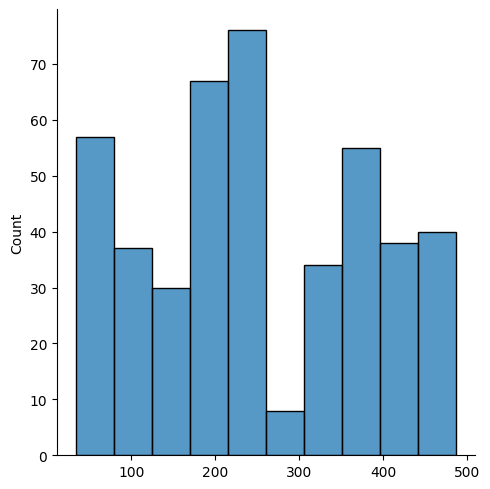

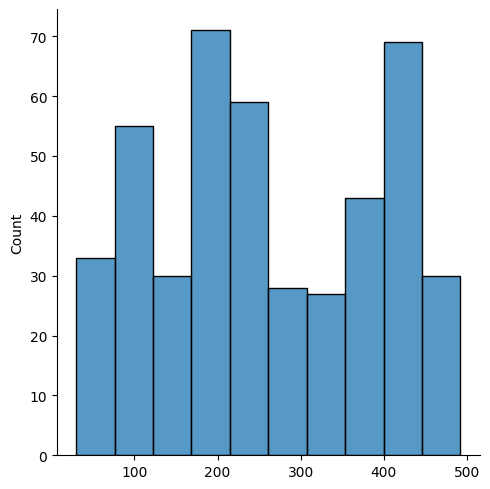

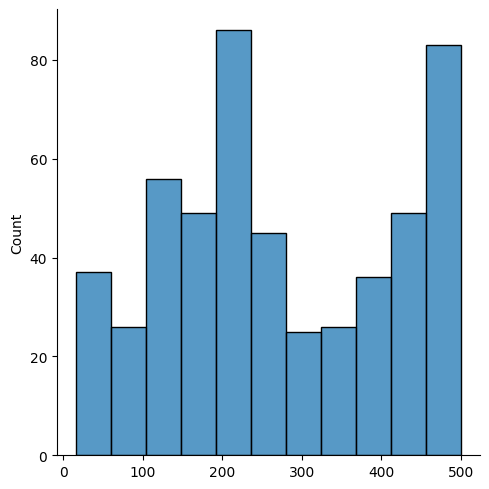

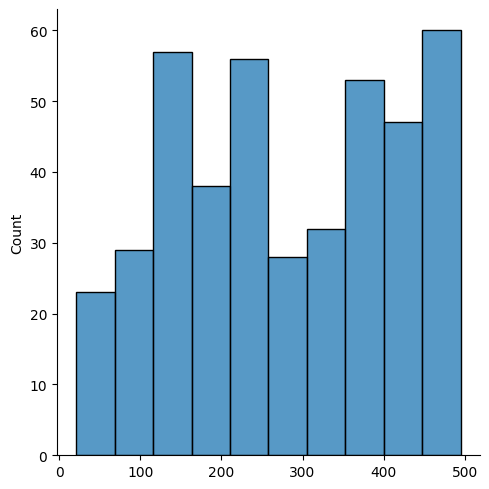

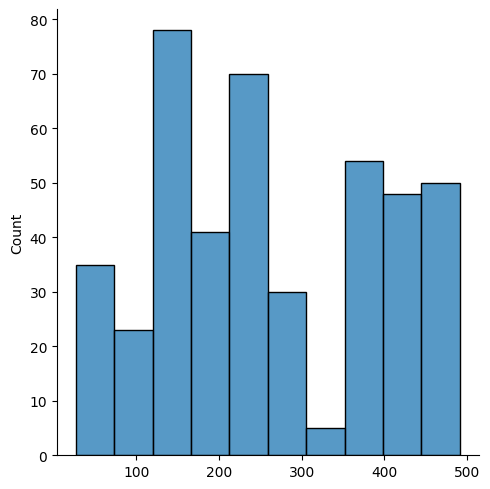

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for s in sets:
    y = [i[1][0] for i in s if i[1][1]==0]
    sns.displot(y)
    plt.show()


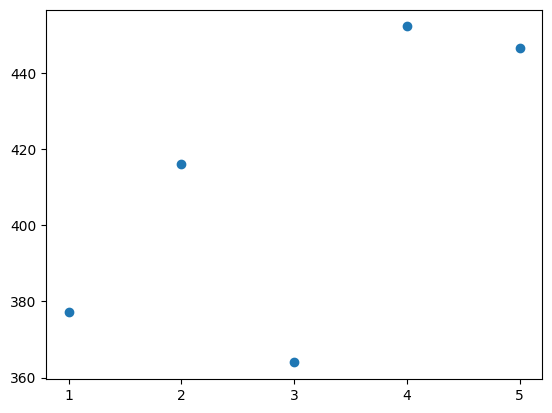

In [33]:
x = [str(i) for i in range(1,6)]
y = [np.mean([i[0][0] for i in s if i[1][1]==1]) for s in sets]
plt.scatter(x,y)

In [17]:
id = -1
temp = []
series = []
for (index, data) in vp.iterrows():         #先把所有同一个id的有价值点组织到一起
    if id == -1 or data[0]== id:  
        if id == -1:
            id = data[0]
        temp.append(index)
    else:
        vp = {'id':id,'index':temp}
        id = data[0]
        temp = [index]
        series.append(vp)
series.append({'id':id, 'index':temp})

In [18]:
series1, series2 = [],[]
mark = 0
for mark in range(len(series)):
    if series[mark]['id'] == 102815655:
        break
series1, series2 = series[:mark], series[mark:]

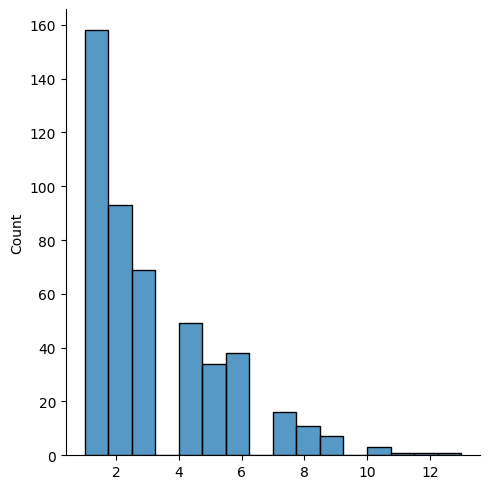

In [21]:
temp = [len(s['index']) for s in series2]
sns.displot(temp)
plt.show()

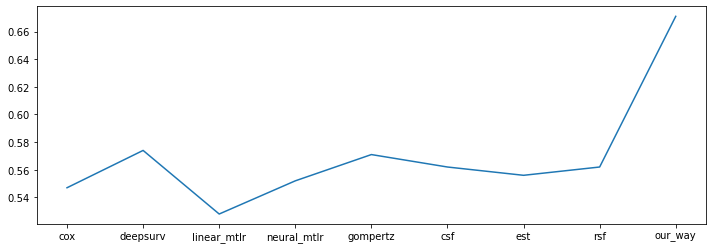

In [7]:
import matplotlib.pyplot as plt

x = ['cox','deepsurv','linear_mtlr','neural_mtlr','gompertz','csf','est','rsf','our_way']
y = [0.547,0.574,0.528,0.552,0.571,0.562,0.556,0.562,0.671]
y2= [0.586,0.643,0.588,0.566,0.558,0.608,0.6,0.6,0.728]
fig = plt.figure(figsize=(12,4))
plt.plot(x,y)
plt.savefig('baseline_point.jpg')